# Test the performances of different FCI implementations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as scy
import scipy.optimize as scyopt
from scipy.spatial.distance import pdist
from sympy import gamma, Float
from numba import jit,njit,prange,vectorize,float64
from sklearn.metrics import pairwise_distances
import h5py 

In [2]:
from tqdm.notebook import tqdm_notebook

In [3]:
rng = np.random.default_rng()

In [4]:
def center_and_normalize(points):
    """
    Center and normalize a dataset of points.

    Parameters
    ----------
    points : array of shape (n_samples, d)
        Input data.

    Returns
    -------
    normalized_points : array of shape (n_samples, d)
        Centered and normalized points.
    """
    n_samples, d = points.shape
    mean = np.mean(points, axis=0)
    centered_points = points - mean

    norms = np.linalg.norm(centered_points, axis=1)
    normalized_points = centered_points / norms[:, np.newaxis]

    return normalized_points

In [5]:
@jit(forceobj=True,fastmath=True)
def analytical_FCI(x,d,x0=1):
    """
    Compute the analytical average full correlation integral on a **d**-dimensional sphere at **x**

    :param x: a real number in (0,2), or a vector of real numbers in (0,2)
    :param d: a real positive number
    :param x0: a real number (should be close to 1). It's such that f(x0)=0.5
    :returns: a real number, or a numpy vector of real numbers
    """
    return  0.5 * ( 1 + float(Float((gamma((1+d)/2)) / (np.sqrt(np.pi) * gamma(d/2) ))) * (-2+(x/x0)**2) * scy.special.hyp2f1( 0.5, 1-d/2, 3/2, 1/4 * (-2+(x/x0)**2)**2 ) )
@jit(forceobj=True,fastmath=True)
def fit_FCI(rho, samples=500, threshold=0.1):
    """
    Given an empirical full correlation integral **rho**, it tries to fit it to the analytical_FCI curve.
    To avoid slow-downs, only a random sample of **samples** points is used in the fitting.
    If the fit fails, it outputs [0,0,0]

    :param rho: vector of shape (N,2) of points in (0,2)x(0,1)
    :param samples: a positive integer
    :returns: the fitted dimension, the fitted x0 parameter and the mean square error between the fitted curve and the empirical points
    """
    samples = min( len(rho),samples )
    data = rho[np.random.choice(len(rho),samples,replace=False)]

    fit = scyopt.curve_fit( analytical_FCI, data[:,0], data[:,1] )
    if abs(fit[0][1] - 1)>threshold:
        return [0,0,0]
    else:
        mse = np.sqrt(np.mean([ (pt[1] - analytical_FCI(pt[0],fit[0][0],fit[0][1]))**2 for pt in data ]))
        return [fit[0][0]+1,fit[0][1],mse]

## Dataset generation

In [6]:
def arc_generator(theta, r=1, dpr=1000):
    """
    theta: angle in radians
    r: radius
    dpr: dots per radian
    """
    N = int(dpr * theta)
    coords = np.zeros((N, 2))
    theta_arc = rng.uniform(0, 1, N) * theta
    coords[:, 0] = r * np.cos(theta_arc)
    coords[:, 1] = r * np.sin(theta_arc)
    return coords

In [7]:
from sklearn.datasets import make_swiss_roll

In [8]:
def make_swiss_roll_f(n_samples=5000, noise=0.):
    swiss_roll, t = make_swiss_roll(n_samples, noise=noise)
    return swiss_roll, t

In [9]:
arc = arc_generator(np.pi)
swiss_roll, t = make_swiss_roll_f(7000)

In [10]:
print(arc.shape)
print(swiss_roll.shape)

(3141, 2)
(7000, 3)


## Performance tests FCI

In [11]:
def FCI(dataset, debug=False, dataset_name=""):
    """
    Compute the full correlation integral of a **dataset** of N d-dimensional points by exact enumeration

    :param dataset: vector of shape (N,d)
    :returns: vector of shape (N(N-1)/2,2)
    """
    num_points = len(dataset)
    num_pairs = num_points * (num_points - 1) // 2
    sorted_distances = np.sort(pdist(dataset))
    if debug:
        with h5py.File(f'distances_FCI_{dataset_name}.h5', 'w') as f:
            f['distances'] = sorted_distances
    correlation_integral = np.empty((num_pairs, 2))
    correlation_integral[:,0] = sorted_distances
    correlation_integral[:,1] = np.arange(0,num_pairs)/num_pairs
    return correlation_integral

In [12]:
def FCI_sklearn(dataset):
    """
    Compute the full correlation integral of a **dataset** of N d-dimensional points by exact enumeration

    :param dataset: vector of shape (N,d)
    :returns: vector of shape (N(N-1)/2,2)
    """
    num_points = len(dataset)
    num_pairs = num_points * (num_points - 1) // 2
    #pair_distances = pdist(dataset)
    pair_distances = pairwise_distances(dataset,n_jobs=4)
    indexes_triu = np.triu_indices(num_points,1)
    sorted_distances = np.sort(pair_distances[indexes_triu])
    correlation_integral = np.empty((num_pairs, 2))
    correlation_integral[:,0] = sorted_distances
    correlation_integral[:,1] = np.arange(0,num_pairs)/num_pairs
    return correlation_integral

In [13]:
@njit(parallel=True,fastmath=True)
def FCI_original(dataset):
    """
    Compute the full correlation integral of a **dataset** of N d-dimensional points by exact enumeration

    :param dataset: vector of shape (N,d)
    :returns: vector of shape (N(N-1)/2,2)
    """
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    for i in prange(n):
        for j in prange(i+1,n):
            c = int( -0.5 * i *  (1 + i - 2 * n) + (j - i) - 1 )
            rs[c] = np.linalg.norm(dataset[i]-dataset[j]) 
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

In [14]:
norm_arc = center_and_normalize(arc)
norm_swiss = center_and_normalize(swiss_roll)

### FCI

In [15]:
fci_fci_arc = FCI(norm_arc)
fit_fci_arc = fit_FCI(fci_fci_arc)
print(fit_fci_arc)

[1.700655042784429, 0.9999942178973584, 0.020371054620964404]


In [16]:
%timeit fci_fci_arc = FCI(norm_arc)

532 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
fci_fci_swiss = FCI(norm_swiss)
fit_fci_swiss = fit_FCI(fci_fci_swiss)
print(fit_fci_swiss)

[2.9321771211727867, 0.9996412586136583, 0.002881128314998355]


In [18]:
%timeit fci_fci_swiss = FCI(norm_swiss)

2.8 s ± 9.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### FCI original

In [19]:
fci_original_arc = FCI_original(norm_arc)
fit_original_arc = fit_FCI(fci_original_arc)
print(fit_original_arc)

[1.7066683089494894, 0.9999991292618952, 0.020237749563553044]


In [20]:
%timeit fci_original_arc = FCI_original(norm_arc)

851 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
fci_original_swiss = FCI_original(norm_swiss)
fit_original_swiss = fit_FCI(fci_original_swiss)
print(fit_original_swiss)

[2.94726685126713, 0.9996110409287082, 0.002506553539636178]


In [22]:
%timeit fci_original_swiss = FCI_original(norm_swiss)

4.49 s ± 87.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### FCI sklearn

In [23]:
fci_sklearn_arc = FCI_sklearn(norm_arc)
fit_sklearn_arc = fit_FCI(fci_sklearn_arc)
print(fit_sklearn_arc)

[1.7052585107343785, 0.9999995638429634, 0.0205141842036155]


In [24]:
%timeit fci_sklearn_arc = FCI_sklearn(norm_arc)

739 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
fci_sklearn_swiss = FCI_sklearn(norm_swiss)
fit_sklearn_swiss = fit_FCI(fci_sklearn_swiss)
print(fit_sklearn_swiss)

[2.9648532735354625, 0.9995862983858115, 0.0022983559187984485]


In [26]:
%timeit fci_sklearn_swiss = FCI_sklearn(norm_swiss)

3.67 s ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Performance Tests Local FCI

In [27]:
from scipy.spatial import KDTree

In [28]:
def compute_id(coords,method = "full", norm = True, debug=False, dataset_name=""):
    """
    compute the ID using FCI
    default FCI; optional Montecarlo FCI
    """
    if norm:
        coord_norm = center_and_normalize(coords)
    else:
        coord_norm = coords
    if method == "full":
        fci = FCI(coord_norm, debug = debug, dataset_name = dataset_name)
    elif method == "montecarlo" or method == "mc":
        fci = FCI_MC(coord_norm)
    else:
        raise ValueError("method must be 'montecarlo' or 'mc' or 'full'")
        return 0
    fit = fit_FCI(fci)
    return fit[0], fci

In [29]:
def local_FCI_dist(dataset, centers, ks, fci_method = "full", debug=False, dataset_name=""):
    """
    Given a **dataset** of N d-dimensional points, the index **center** of one of the points and a list of possible neighbourhoods **ks**, it estimates the local intrinsic dimension by using **fit_FCI()** of the reduced dataset of the first k-nearest-neighbours of **dataset[center]**, for each k in **ks**

    At the moment, it uses FCI_MC and fit FCI with default parameters

    :param dataset: a vector of shape (N,d)
    :param centers: the indexes of a set of points in **dataset**
    :param ks: list or array of increasing positive integers
    :param fci_method: string indicating the FCI variant to use for ID computation. default 'full', other options: 'montecarlo'('mc')
    :returns local: a vector of shape (len(centers),len(ks),2). For each k in **ks**, returns the list [ k, fitted dimension] 
    :returns selected_dists: a vector of shape (len(centers),len(ks)). For each k in **ks**, returns the list of the distances of the first k nearest neighbors of **dataset[centers]** 
    :returns selected_neighbors_indexes: a vector of shape (len(centers),len(ks)). For each k in **ks**, returns the list of the indexes of the first k nearest neighbors of **dataset[centers]**
    """
    tree = KDTree(dataset)
  
    local = np.empty(shape=(len(centers),len(ks),2))
    k_max = ks[-1]
    selected_dists, neighbors_indexes = tree.query(dataset[centers], k_max + 1, workers=-1)

    #for i in tqdm_notebook(range(len(centers))):
    for i in prange(len(centers)):
        #norm_dataset = center_and_normalize(dataset[neighbors_indexes[i][:-1]])
        for j, k in enumerate(ks):
            #neighbors = norm_dataset[:k]
            #fit, fci = compute_id(neighbors, fci_method, debug = debug, norm=False, dataset_name = f"{dataset_name}_{centers[i]}_{k}")
            neighbors = dataset[neighbors_indexes[i][:k]]
            fit, fci = compute_id(neighbors, fci_method, debug = debug, dataset_name = f"{dataset_name}_{centers[i]}_{k}")
            local[i][j] = [k, fit]
    return local, selected_dists, neighbors_indexes

In [30]:
def local_FCI(dataset, center, ks, method = "mc"):
    """
    Given a **dataset** of N d-dimensional points, the index **center** of one of the points and a list of possible neighbourhoods **ks**, it estimates the local intrinsic dimension by using **fit_FCI()** of the reduced dataset of the first k-nearest-neighbours of **dataset[center]**, for each k in **ks**

    At the moment, it uses FCI_MC and fit FCI with default parameters

    :param dataset: a vector of shape (N,d)
    :param center: the index of a point in **dataset**
    :param ks: list of increasing positive integers
    :param method: either "mc" or "full" (default = "mc") FCI method used to compute the local FCI
    :returns: a vector of shape (len(ks),5). For each k in **ks**, returns the list [ k, distance between dataset[center] and the k-th neighbour, fitted dimension, fitted x0, the mean square error of the fit ] 
    """
    neighbours = dataset[np.argsort(np.linalg.norm( dataset - dataset[center], axis=1))[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    if method == "mc":
        for i, k in enumerate(ks):
            fit = fit_FCI( FCI_MC( center_and_normalize( neighbours[0:k] ) ) )
            local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]
    elif method == "full":
        for i, k in enumerate(ks):
            fit = fit_FCI( FCI( center_and_normalize( neighbours[0:k] ) ) )
            local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]
    else:
        raise ValueError("method must be 'mc' or 'full'")

    return local

In [31]:
def local_FCI_wrapper(dataset, centers, ks, method = "full"):
    local = np.empty(shape=(len(centers),len(ks),5))
    #for i, center in tqdm_notebook(enumerate(centers)):
    for i, center in enumerate(centers):
        local[i] = local_FCI(dataset, center, ks, method)
    return local

In [32]:
from sklearn.metrics import pairwise_distances

In [33]:
def local_FCI_fast(dataset, centers, ks, fci_method = "full", debug=False, dataset_name=""):
    """
    Given a **dataset** of N d-dimensional points, the index **center** of one of the points and a list of possible neighbourhoods **ks**, it estimates the local intrinsic dimension by using **fit_FCI()** of the reduced dataset of the first k-nearest-neighbours of **dataset[center]**, for each k in **ks**

    At the moment, it uses FCI_MC and fit FCI with default parameters

    :param dataset: a vector of shape (N,d)
    :param centers: the indexes of a set of points in **dataset**
    :param ks: list or array of increasing positive integers
    :param fci_method: string indicating the FCI variant to use for ID computation. default 'full', other options: 'montecarlo'('mc')
    :returns local: a vector of shape (len(centers),len(ks),2). For each k in **ks**, returns the list [ k, fitted dimension] 
    :returns selected_dists: a vector of shape (len(centers),len(ks)). For each k in **ks**, returns the list of the distances of the first k nearest neighbors of **dataset[centers]** 
    :returns selected_neighbors_indexes: a vector of shape (len(centers),len(ks)). For each k in **ks**, returns the list of the indexes of the first k nearest neighbors of **dataset[centers]**
    """
    tree = KDTree(dataset)
  
    local = np.empty(shape=(len(centers),len(ks),2))
    k_max = ks[-1]
    neighbors_dists, neighbors_indexes = tree.query(dataset[centers], k_max + 1, workers=-1)

    #for i in tqdm_notebook(range(len(centers))):
    for i in range(len(centers)):
        selected_data = dataset[neighbors_indexes[i][:-1]]
        normalized = center_and_normalize(selected_data)
        pair_dist = pairwise_distances(normalized, n_jobs=-1)
        if debug:
            print(pair_dist[:3,:3])
            fig, ax = plt.subplots()
        for j, k in enumerate(ks):
            n_points = k * ( k - 1 ) // 2
            indexes  = np.triu_indices(k,1)
            selected_dists = np.sort(pair_dist[indexes])
            correlation_integral = np.array([selected_dists, np.arange(0,n_points)/n_points]).T
            if debug:
                print(selected_dists[:3])
                print(selected_dists.shape,correlation_integral.shape, n_points, indexes[0][0],indexes[0][-1],indexes[1][0], indexes[1][-1],k)
                ax.plot(correlation_integral[:,0], correlation_integral[:,1])
                with h5py.File(f"distances_{dataset_name}_{centers[i]}_fast.hdf5", "a") as f:
                    f[f"distances_{k}"] = selected_dists
            fit = fit_FCI(correlation_integral)
            local[i][j] = [k, fit[0]]
        if debug: 
            plt.show()

    return local, neighbors_dists, neighbors_indexes

In [34]:
centers_arc = rng.choice(len(arc), size=3, replace=False)

In [35]:
centers_swiss = rng.choice(len(swiss_roll), size=3, replace=False)

In [36]:
neighbors = [10, 30, 50,100, 200, 300, 400, 500]

### Local FCI dist

In [37]:
local_dist_arc_d = local_FCI_dist(arc, centers_arc, neighbors)
local_dist_swiss_d = local_FCI_dist(swiss_roll, centers_swiss, neighbors)

In [38]:
%timeit local_FCI_dist(arc, centers_arc, neighbors)
%timeit local_FCI_dist(swiss_roll, centers_swiss, neighbors)

13.7 s ± 432 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.8 s ± 218 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Local FCI

In [39]:
local_dim_arc_w = local_FCI_wrapper(arc, centers_arc, neighbors)
local_dim_swiss_w = local_FCI_wrapper(swiss_roll, centers_swiss, neighbors)

In [40]:
%timeit local_FCI_wrapper(arc, centers_arc, neighbors)
%timeit local_FCI_wrapper(swiss_roll, centers_swiss, neighbors)

14.5 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.86 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Local FCI fast

In [41]:
local_dim_arc = local_FCI_dist(arc, centers_arc[:2], neighbors[:3], debug=True, dataset_name="arc")

[[0.         0.00269647 0.00371027]
 [0.00269647 0.         0.00640673]
 [0.00371027 0.00640673 0.        ]]
[0.0005403  0.00269647 0.00360921]
(45,) (45, 2) 45 0 8 1 9 10
[0.0001785  0.00032354 0.00050204]
(435,) (435, 2) 435 0 28 1 29 30
[3.65774188e-06 9.63887460e-06 1.68553344e-05]
(1225,) (1225, 2) 1225 0 48 1 49 50


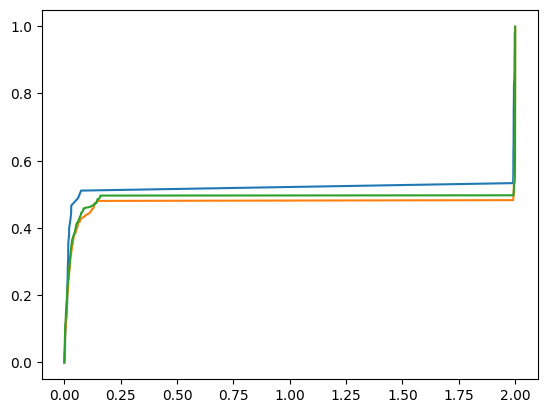

[[0.         0.07689618 0.22501437]
 [0.07689618 0.         0.30125596]
 [0.22501437 0.30125596 0.        ]]
[0.00443079 0.00805953 0.01023956]
(45,) (45, 2) 45 0 8 1 9 10
[1.07438406e-05 9.43237730e-05 1.90544724e-04]
(435,) (435, 2) 435 0 28 1 29 30
[1.07438406e-05 1.76065055e-05 5.19654576e-05]
(1225,) (1225, 2) 1225 0 48 1 49 50


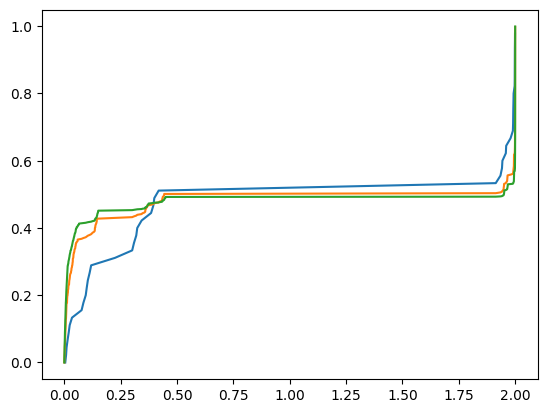

In [42]:
local_dim_arc_fast = local_FCI_fast(arc, centers_arc[:2], neighbors[:3], debug=True, dataset_name="arc")

In [43]:
with h5py.File(f"distances_arc_{centers_arc[0]}_fast.hdf5", "r") as f:
    distances = f[f"distances_{neighbors[1]}"][:]

In [44]:
with h5py.File(f"distances_FCI_arc_{centers_arc[0]}_{neighbors[1]}.h5", "r") as f:
    distances_fci = f[f"distances"][:]

In [45]:
print(centers_arc[0], neighbors[1])

453 30


In [46]:
print(distances.shape, distances_fci.shape)

(435,) (435,)


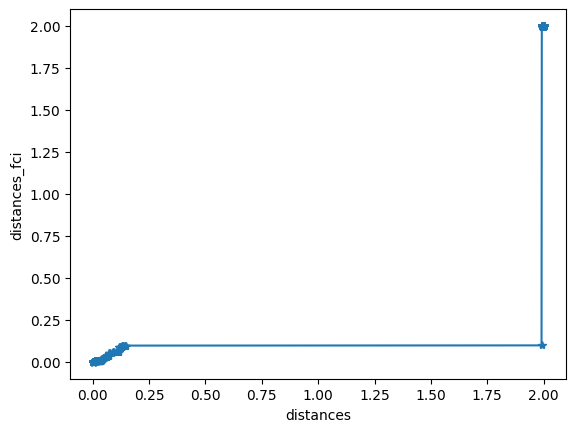

In [47]:
fig, ax = plt.subplots()
ax.plot(distances, distances_fci, '*-')
ax.set_xlabel("distances")
ax.set_ylabel("distances_fci")
plt.show()

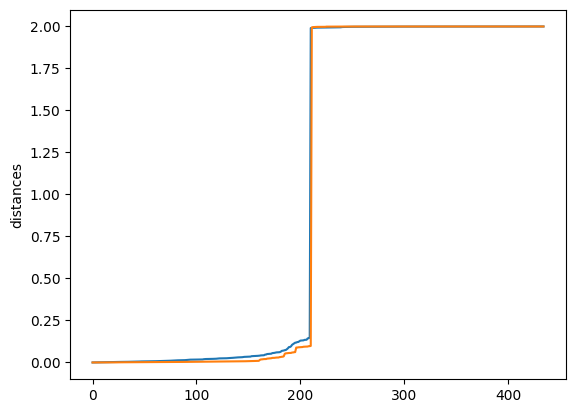

In [48]:
fig, ax = plt.subplots()
ax.plot(distances)
ax.plot(distances_fci)
ax.set_ylabel("distances")
plt.show()

In [49]:
print(local_dim_arc[0])

[[[10.          1.1366749 ]
  [30.          1.15251951]
  [50.          1.20828518]]

 [[10.          1.11998272]
  [30.          1.17980154]
  [50.          1.18807881]]]


In [50]:
print(local_dim_arc_fast[0])

[[[10.          1.19711575]
  [30.          1.19928245]
  [50.          1.20937891]]

 [[10.          1.28734621]
  [30.          1.23267058]
  [50.          1.1615821 ]]]


In [51]:
local_dim_arc_f = local_FCI_fast(arc, centers_arc, neighbors)
local_dim_swiss_f = local_FCI_fast(swiss_roll, centers_swiss, neighbors)

/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)


In [52]:
%timeit local_FCI_fast(arc, centers_arc, neighbors)
%timeit local_FCI_fast(swiss_roll, centers_swiss, neighbors)

/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(correlation_integral)
/tmp/ipykernel_21643/3218084501.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  fit = fit_FCI(

8.76 s ± 700 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.1 s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Check

#### Local W

In [53]:
print(local_dim_arc_w[0][:,(0,2)])

[[ 10.           1.13667489]
 [ 30.           1.15251951]
 [ 50.           1.21255142]
 [100.           1.21655795]
 [200.           1.25148779]
 [300.           1.29470861]
 [400.           1.31485178]
 [500.           1.32697789]]


#### Local dist

In [54]:
print(local_dist_arc_d[0][0])

[[ 10.           1.1366749 ]
 [ 30.           1.15251951]
 [ 50.           1.20928453]
 [100.           1.21043403]
 [200.           1.26676784]
 [300.           1.29207116]
 [400.           1.30967633]
 [500.           1.31396478]]


#### Fast

In [55]:
print(local_dim_arc_f[0][0])

[[ 10.           0.        ]
 [ 30.           0.        ]
 [ 50.           1.59483635]
 [100.           1.57528963]
 [200.           1.52870788]
 [300.           1.43637897]
 [400.           1.3867455 ]
 [500.           1.36699192]]


## Conclusions

The development of a fast localFCI algorithm clashes with the need of a local normalization of the neighborhood: normalizing the neighborhood before computing the distances on the largest neighborhood and then using them for the smaller ones introduces an unwanted bias.